In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
from tools import *
# from h5_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/

total 41853344
-rw-rw-r--+ 1 mabi3848 hpc-users  120392345 Jul 11 15:18 apo_conc_gly_50_2_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users      23079 Jun 28 14:11 background_0003.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1161373434 Jul 11 15:35 ferritin_conc100_gly_50_1_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  703980477 Jul 11 15:39 ferritin_conc100_gly_50_1_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2330393309 Jul 11 15:54 ferritin_conc100_gly_50_1_0009.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1144299172 Jul 11 15:43 ferritin_conc100_gly_50_1_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2461504414 Jul 11 16:12 ferritin_conc100_gly_50_1_0012.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2539875762 Jul  5 17:15 ferritin_conc100_gly_50_1_0013.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1604681690 Jul  5 17:06 ferritin_conc100_gly_50_1_0014.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  745507304 Jul 13 15:11 ferritin_conc100_gly_50_2_0010.h5
-rw-rw-r--+ 1 mabi3848 hpc-users  527515584 Jul 13 11:03 ferritin_conc100_gly_50_2_0011.h5
-rw-rw-

In [5]:
runnames = ['ferritin_conc_gly_50_6', 'ferritin_conc100_gly_50_1', 'ferritin_conc120_gly_50_1']
datasetnumbers = [3,9,7] # 240 K


In [6]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 
File exists:  True 

measurement folder   ferritin_conc100_gly_50_1_0009
Temperature, K       240.0
transmission (%)     nan
Absorbers 80um       nan
Absorbers 100um      nan
Short comment        nan
comment              nan
Exposure time (s)    nan
number of frames     nan
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 
File exists:  True 

measurement folder   ferritin_conc120_gly_50_1_0007
Temperature, K       240.0
transm

# Plot g2s

In [7]:
# with h5py.File( h5dir + f'{runnames[-1]}_{datasetnumbers[-1]:04d}.h5', 'r') as f: 
#     f.visititems(visit_func)

In [8]:
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
len_g2 = len(load_data(filename, 'xpcs/g2s/delay'))
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len_g2))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len_g2))
delays = np.empty(shape=(len(datasetnumbers),len_g2))

for i, (datasetnumber,runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    print(filename, os.path.isfile(filename))
    
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')


/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc100_gly_50_1_0009.h5 True
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc120_gly_50_1_0007.h5 True


In [9]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')
etas = viscosity()
eta_50 = {} #etas['50w%']
for i in etas.index:
    # print(i, etas.iloc[i]['temp'], etas.iloc[i]['50w%'])
    key = etas.iloc[i]['temp']
    eta_50[key] = etas.iloc[i]['50w%']
eta_50

{300.0: 0.0046742,
 290.0: 0.0067715,
 280.0: 0.010448,
 270.0: 0.01749,
 260.0: 0.032565,
 250.0: 0.06989,
 240.0: 0.18269,
 230.0: 0.63521,
 220.0: 3.4169,
 210.0: 37.846}

### With kww=1

In [30]:
concs_l = ['c1', 'c2', 'c3']
concs = [31, 44, 64]


 31
240 54919.77948081964 621.6412400956954

 44
240 15547.008511864551 218.12656191121482

 64
240 5485.233831880712 120.37508242612257


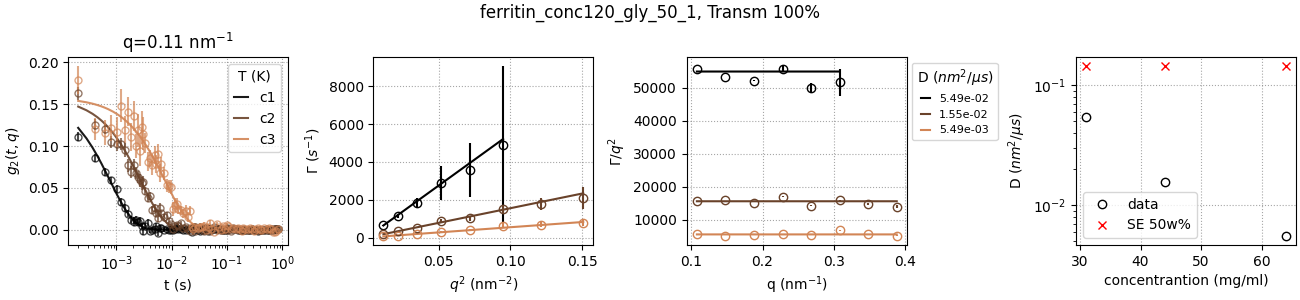

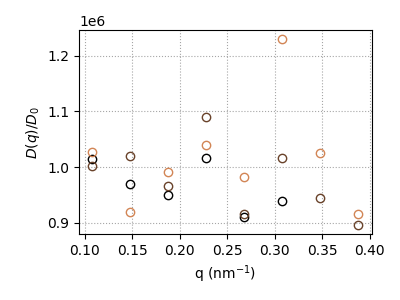

In [31]:
f, (a1,a3,a4,a2) = plt.subplots(1,4, figsize=(13,3), constrained_layout=True)
f2, a5 = plt.subplots(1,1, figsize=(4,3), tight_layout=True)

col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)+1))
qv_sel = 2
tol = 1e-3

qv_min, qv_max, qstep = 2, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    print('\n', concs[i])
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            # a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{concs_l[i]}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)

    cond = (taus>dtaus) & (dtaus!=0)
    # print(T[i][:-2], qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2))
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    print(T[i][:-2],  popt[0], perr[0])

    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a4.plot(np.sqrt(xc), curve/xc, c=col[i], label=f'{Ds[0,i]:.2e}')
    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    a4.errorbar(qs[cond], 1/taus[cond]/qs[cond]**2, dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a2.plot(concs[i], Ds[0,i], ls='', marker='o', mfc='none', c='k')
    a2.plot(concs[i], D_coeff(T=float(T[i]), eta=eta_50[float(T[i])])*1e12 , ls='', marker='x', mfc='none', c='r')

    a5.plot(qs[cond], 1/taus[cond]/qs[cond]**2/Ds[0,i], c=col[i], ls='', marker='o', mfc='none')

a1.legend(title=r'T (K)', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_title(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$")
f.suptitle(f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
# a3.set_ylim(0,1e4)
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma/q^2$')
a2.set_xlabel('concentrantion (mg/ml)')
a2.set_ylabel('D (${{nm}}^{{2}}$/${{\mu s}}$)')
a2.set_yscale('log')
a4.legend(title='D (${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.8, bbox_to_anchor=[1,1])
a2.legend(['data', 'SE 50w%'], fontsize=10)
a5.set_xlabel(r'q (nm$^{-1}$)')
a5.set_ylabel(r'$D(q)/D_0$');

In [32]:
qv

array([0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348,
       0.388, 0.428, 0.468])

# Scattering intensity

In [13]:
filename = h5dir + f'{runnames[0]}_{datasetnumbers[0]:04d}.h5'
rep = 0
qI = load_data(filename, '/saxs/q') # 1000

Iqs = np.empty(shape=(len(datasetnumbers),len(qI)))
t_exp = []

for i,(datasetnumber,runname) in enumerate(zip(datasetnumbers,runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    Iqs[i,:] = load_data(filename, '/saxs/I_reps_filtered')[rep,:] # (4, 1000)
    info = elog_selected_entries_dict(filename)
    t_exp.append(delays[i,0])
    print(datasetnumber, f'{t_exp[i]:.4f}', 's')

print(np.shape(Iqs), np.shape(qI))

3 0.0002 s
9 0.0002 s
7 0.0002 s
(3, 1000) (1000,)


In [14]:
# bkg 0003 "vacuum"
f = np.load("../03-source/bkg_background_0003.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg = f['Iq']
q_bkg = f['q']
t_exp_bkg = 1e-1

# water/glycerol
f = np.load("../03-source/bkg_water_gly_50_2_0002.npz")
print(f.files)
# Iq_bkg = np.average(f['Iq'][:2,:], axis=0)
Iq_bkg_w = f['Iq'][2,:]
q_bkg_w = f['q']
t_exp_bkg_w = 1e-1

# apoferritin
# f = np.load("../03-source/Iqs_apo_conc_gly_50_2_0006.npz")
# f.files
# Iq_apo = np.average(f['Iqs'],axis=0)
# q_apo = f['q']
# t_exp_apo = 5e-3

# apoferritin short exp time
f = np.load("../03-source/bkg_apo_conc_gly_50_2_0002.npz")
f.files
Iq_apo = f['Iq']
q_apo = f['q']
t_exp_apo = 0.0002

['Iq', 'q']
['Iq', 'q']


In [15]:
from scipy.ndimage import gaussian_filter

In [17]:
ff = np.load('../03-source/nice_Iq_c1.npz')
Iq_nice = ff['Iq']
q_nice = ff['q']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


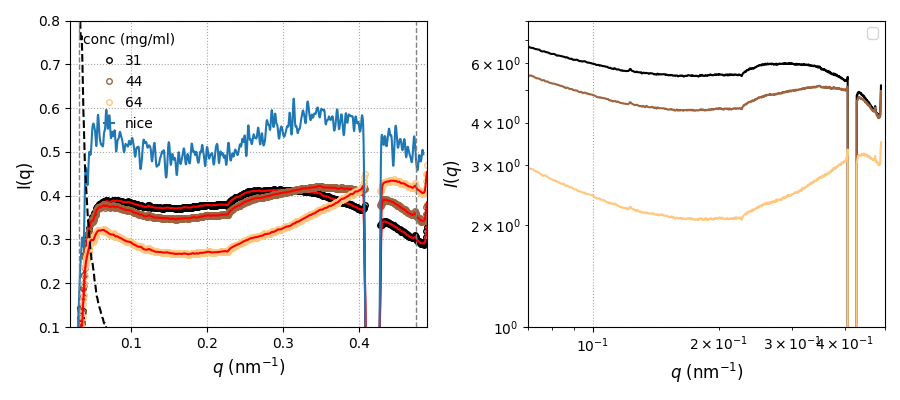

In [48]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_index = 50
# q_index = 5
for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    y = Iqs[i,:]/Iqs[i,q_index] - Iq_bkg/Iq_bkg[q_index]
    y_smooth = gaussian_filter(y, sigma=2)

    a1.plot(qI, y, ls='', marker='o', ms=4, mfc='none', c=col[i], label=concs[i]) # subtract the lowest conc
    a1.plot(qI, y_smooth, ls='-', c='r') # subtract the lowest conc

    # a1.plot(qI, Iqs[i,:]/Iqs[i,q_index] - Iq_apo[:]/Iq_apo[q_index], ls='-', c=col[i], label=concs[i]) # subtract apof
    # a2.plot(qI, Iqs[i,:]/Iqs[i,q_index] , ls='-', c=col[i], label=concs[i])
    
    # a1.plot(qI, Iqs[i,:], ls='-', c=col[i], label=concs[i])
    a2.plot(qI, Iqs[i,:]/t_exp[i], ls='-', c=col[i])

    # y = Iqs[i,:]-Iq_bkg/t_exp_bkg*t_exp[i]# - Iq_bkg/Iq_bkg[6]*Iqs[i,6]
    # y = Iqs[i,:] - Iq_bkg/Iq_bkg[q_index]*Iqs[i,q_index]
    # a2.plot(qI, y, c=col[i], ls='-', label=concs[i])
y = Iq_nice/Iq_nice[q_index] - Iq_bkg[:-10]/Iq_bkg[q_index]
a1.plot(q_nice, gaussian_filter(y, sigma=2), ls='-', c='C0', label='nice')


a1.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a1.axvline(x=.475, ls='--', c='gray', lw=1)
a2.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
# a1.set_xscale('log')
# a1.set_yscale('log')
a1.set_xlim(.02,qI[-1])
a1.set_ylim(0.1,.8)

# a1.set_ylim(7e-1,1.5e0)
a2.set_ylabel('$I(q)$', fontsize=12)
a2.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a2.set_xscale('log')
a2.set_yscale('log')
a2.set_xlim(.07,.5)
a2.set_ylim(1e0,8)
a2.legend()

(0.0, 1.0)

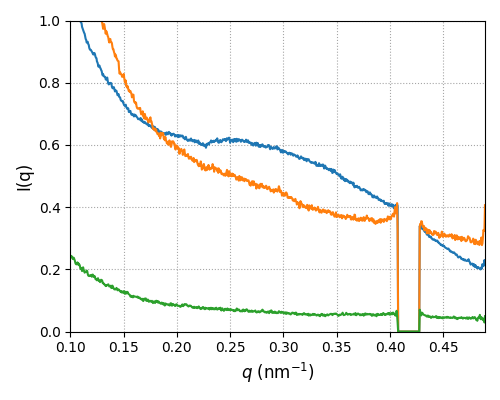

In [24]:
f, (a1) = plt.subplots(1,1, figsize=(5,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_index = 450

# a1.plot(q_apo, Iq_apo, ls='-', label='apof')

a1.plot(q_apo, Iq_apo/t_exp_apo, ls='-', label='apof')
a1.plot(q_bkg, Iq_bkg/t_exp_bkg, ls='-', label='empty')
a1.plot(q_bkg_w, Iq_bkg_w/t_exp_bkg_w, ls='-', label='wat/gl')

# a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
# a1.set_xscale('log')
# a1.set_yscale('log')
a1.set_xlim(.1,qI[-1])
a1.set_ylim(0,1e0)

## log interpolation

In [36]:
import scipy as sp
import scipy.interpolate

In [44]:
q_new = [0.028, 0.068, 0.108, 0.148, 0.188, 0.228, 0.268, 0.308, 0.348, 0.388, 0.468]

(0.1, 0.8)

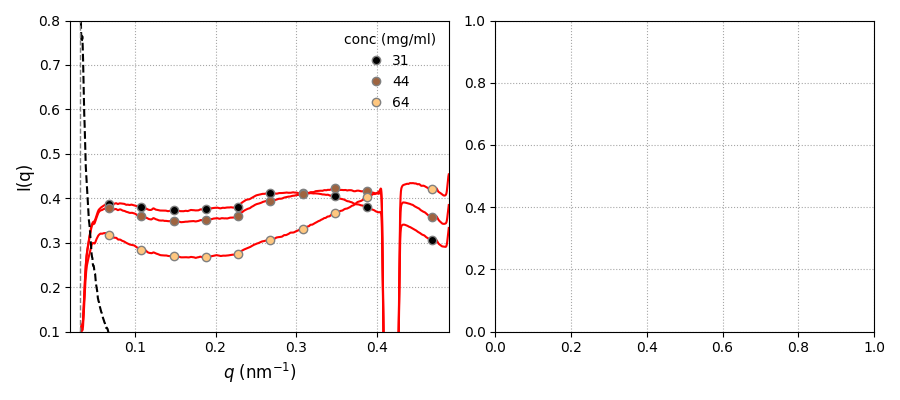

In [55]:
f, (a1,a2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))

q_index = 50
# q_index = 5
for i in range(len(datasetnumbers)):
    # a1.plot(qI, Iqs[i,:]*(1-float(Tr[i])/100), ls='-', c=col[i], label=f'{Tr[i]}')
    y = Iqs[i,:]/Iqs[i,q_index] - Iq_bkg/Iq_bkg[q_index]
    y_smooth = gaussian_filter(y, sigma=2)
    
    # a1.plot(qI, y, ls='', marker='o', ms=4, mfc='none', c=col[i], label=concs[i]) # subtract the lowest conc
    a1.plot(qI, y_smooth, ls='-', c='r') # subtract the lowest conc

    # interpolate
    y_interp =  sp.interpolate.interp1d(qI, y_smooth, kind='linear')
    a1.plot(q_new, y_interp(q_new), marker='o', mec='gray', c=col[i], ls='',  label=concs[i])

a1.plot(qI, Iq_bkg/Iq_bkg[q_index], ls='--', c='k')
a1.axvline(x=qI[q_index], ls='--', c='gray', lw=1)

# for q in qv:
#     a1.axvline(x=q, c='gray', ls='--')

a1.legend(title='conc (mg/ml)', handlelength=.7, frameon=False)
a1.set_xlabel(r'$q$ (nm$^{-1}$)', fontsize=12)
a1.set_ylabel('I(q)', fontsize=12)
a1.set_xlim(.02,qI[-1])
a1.set_ylim(0.1,.8)


In [86]:
xfel['D'][i,0]

2.0380126160910867


 31
[55760.20199661 53249.62053227 52164.99875739 55780.10527893
 50002.1696417  51597.19686121]

 44
[15579.88504523 15871.02740015 15011.40241322 16943.12594527
 14242.48978151 15804.05563963 14695.17767935 13939.34756967]

 64
[5631.06497103 5041.78250575 5436.08786575 5701.10266929 5392.67089993
 6740.29006389 5620.21309063 5025.59832772]


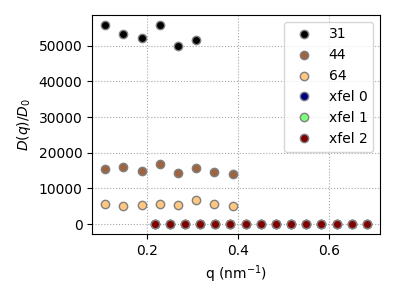

In [88]:
f, a1 = plt.subplots(1,1, figsize=(4,3), tight_layout=True)
col = plt.cm.copper(np.linspace(0,1,len(datasetnumbers)))
col2 = plt.cm.jet(np.linspace(0,1,3))

# -- id10
qv_sel, tol = 2, 1e-3
qv_min, qv_max, qstep = 2, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    print('\n', concs[i])
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0)
    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    # a1.plot(qs[cond], 1/taus[cond]/qs[cond]**2/Ds[0,i], c=col[i], ls='', marker='o', mec='gray', label=concs[i])
    a1.plot(qs[cond], 1/taus[cond]/qs[cond]**2, c=col[i], ls='', marker='o', mec='gray', label=concs[i])
    print(1/taus[cond]/qs[cond]**2)

# -- xfel

for i in range(3):
    a1.plot(xfel['qvalues'], xfel['D'][i,:], c=col2[i], marker='o', mec='gray', ls='', label=f'xfel {i}')

# a2.set_xlabel('q (1/nm)')
# a2.set_ylabel('D(q)')

a1.set_xlabel(r'q (nm$^{-1}$)')
a1.set_ylabel(r'$D(q)/D_0$')
a1.legend()

# XFEL ferritin

In [62]:
f = np.load("../03-source/xfel.npz")
xfel = {}
for key in f.files:
    xfel[key] = f[key]
    print(key, np.shape(xfel[key]))

q_form_factor (256,)
form_factor (256,)
H_theory (2999, 3)
S_theory (2999, 3)
q_theory (2999,)
qvalues (15,)
dH_Q (3, 15)
H_Q (3, 15)
D (3, 15)
dD (3, 15)


Text(0, 0.5, 'D(q)')

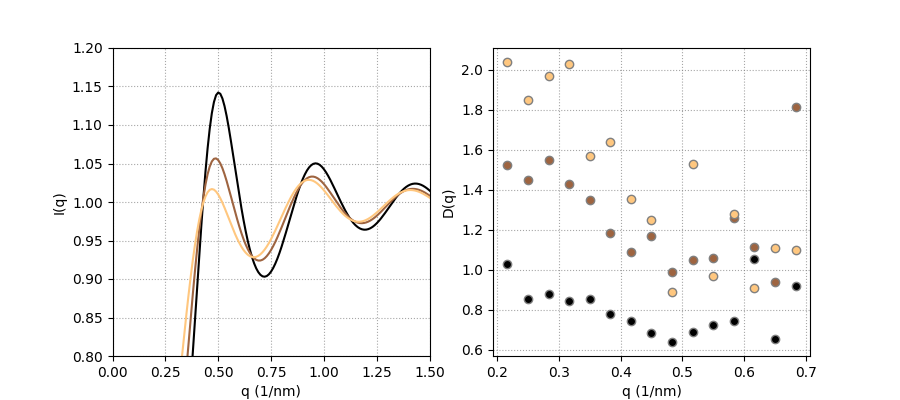

In [76]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(9,4))
cols = plt.cm.copper(np.linspace(0,1,3))
# -- I(q) S(q)
# a1.plot(xfel['q_form_factor'], xfel['form_factor'])

for i in range(3):
    a1.plot(xfel['q_theory'], xfel['S_theory'][:,i], c=cols[i], label=i)

a1.set_xlabel('q (1/nm)')
a1.set_ylabel('I(q)')
a1.set_ylim(0.8,1.2)
a1.set_xlim(0,1.5)

# -- D(q), H(q)
for i in range(3):
    a2.plot(xfel['qvalues'], xfel['D'][i,:], c=cols[i], marker='o', mec='gray', ls='', label=i)

a2.set_xlabel('q (1/nm)')
a2.set_ylabel('D(q)')
# a2.set_ylim(0.8,1.2)
# a1.set_xlim(0,1.5)
